# COVID-19 Italian Data

### Import

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import math

### Read Data

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/DavideMagno/ItalianCovidData/master/Daily_Covis19_Italian_Data_Cumulative.csv')

df.head()

,Date,Region,Hospitalised,In ICU,Home Isolation,Healed,Dead,Tests
0,2020-02-25,Lombardia,76,21,109,0,6,3298
1,2020-02-25,Veneto,14,5,18,0,1,2200
2,2020-02-25,Emilia Romagna,12,2,9,0,0,148
3,2020-02-25,Piemonte,2,0,1,0,0,141
4,2020-02-25,Lazio,1,1,0,1,0,124


### Data Manipulation

In [3]:
# group by date
df_g = df.groupby(['Date']).sum()
df_g.tail()

,Hospitalised,In ICU,Home Isolation,Healed,Dead,Tests
Date,,,,,,
2020-03-03,1034,229,1000,160,79,25856
2020-03-04,1346,295,1065,276,107,29837
2020-03-05,1790,351,1155,414,148,32362
2020-03-06,2394,462,1060,523,197,36359
2020-03-07,2651,567,1843,589,233,42062


### Plot

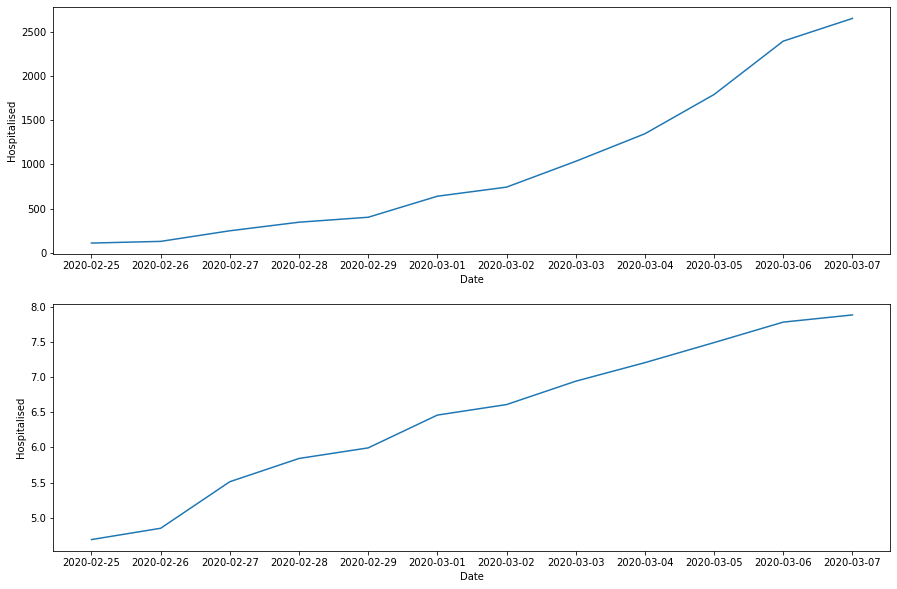

In [4]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig.set_size_inches(15,10)

sns.lineplot(df_g.index, df_g.Hospitalised, ax=ax1)
sns.lineplot(df_g.index, df_g.Hospitalised.apply(lambda x: math.log(x)), ax=ax2)

### Exponential model

In [5]:
# From date to number

df_g.index = pd.to_datetime(df_g.index)
df_g['Date_n'] = df_g.index.to_julian_date()

In [6]:
# Normalize number and compute logs

df_g['Date_n'] = df_g.Date_n - 2458904.5
df_g['log_hosp'] = df_g.Hospitalised.apply(lambda x: math.log(x))

In [13]:
# Linear model is part of Gaussian family
X = df_g.Date_n
X = sm.add_constant(X)
y = df_g.log_hosp

model = sm.OLS(y, X).fit()

# model = sm.formula.glm("log_hosp ~ Date_n",
#                       family=sm.families.Gaussian(), data=df_g).fit()

In [14]:
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.985   
Dependent Variable: log_hosp         AIC:                -12.3789
Date:               2020-03-07 21:11 BIC:                -11.4091
No. Observations:   12               Log-Likelihood:     8.1895  
Df Model:           1                F-statistic:        705.5   
Df Residuals:       10               Prob (F-statistic): 1.32e-10
R-squared:          0.986            Scale:              0.017945
-------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
const        4.8021     0.0727   66.0159   0.0000   4.6400   4.9642
Date_n       0.2975     0.0112   26.5612   0.0000   0.2726   0.3225
-----------------------------------------------------------------
Omnibus:               1.375        Durbin-Watson:          1.476
Prob(Omnibus):         0.503        Jarque-Bera (JB):       0.885
Skew:                  -0.623       Prob(JB):               0.642
Kurtosis:              2.534        Condition No.:          12   
=================================================================

"""

In [26]:
# Calculate predicted data

X_fit = df_g.Date_n
X_fit = sm.add_constant(X_fit)

predict_frame = model.get_prediction(X_fit)
predict_frame = predict_frame.summary_frame()

log_predicted, log_predicted_lower, log_predicted_upper = np.array(predict_frame['mean']), np.array(predict_frame.mean_ci_lower), np.array(predict_frame.mean_ci_upper)

exper = lambda t: math.exp(t)
vfunc = np.vectorize(exper)
predicted, predicted_lower, predicted_upper = vfunc(log_predicted), vfunc(log_predicted_lower), vfunc(log_predicted_upper)

Text(0, 0.5, 'log_hospitalized')

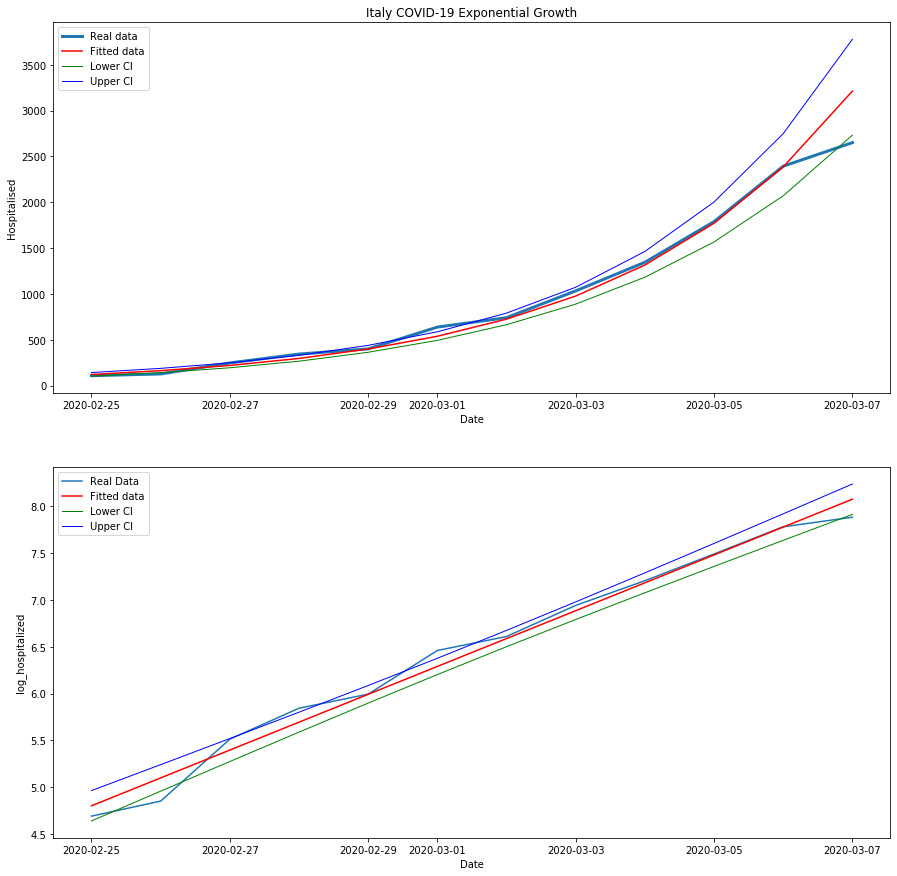

In [31]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig.set_size_inches(15,15)

ax1.set_title('Italy COVID-19 Exponential Growth')

# exponential
sns.lineplot(df_g.index, df_g.Hospitalised, ax=ax1, label='Real data', lw=3)
sns.lineplot(x=df_g.index,y=predicted, color='red', ax=ax1, label='Fitted data')
# CI
sns.lineplot(x=df_g.index,y=predicted_lower, color='green', ax=ax1, label='Lower CI', lw=1)
sns.lineplot(x=df_g.index,y=predicted_upper, color='blue', ax=ax1, label='Upper CI', lw=1)

# log
sns.lineplot(df_g.index, df_g.Hospitalised.apply(lambda x: math.log(x)), ax=ax2, label='Real Data')
sns.lineplot(x=df_g.index,y=log_predicted, color='red', ax=ax2, label='Fitted data')
# CI
sns.lineplot(x=df_g.index,y=log_predicted_lower, color='green', ax=ax2, label='Lower CI', lw=1)
sns.lineplot(x=df_g.index,y=log_predicted_upper, color='blue', ax=ax2, label='Upper CI', lw=1)
ax2.set_ylabel('log_hospitalized')

### Predict

In [32]:
# Try to see the future

df_predicted = pd.DataFrame(np.linspace(0,30), columns=['Date_n'])

In [35]:
X_fit = df_predicted.Date_n
X_fit = sm.add_constant(X_fit)

log_predicted = np.array(model.predict(X_fit))
predicted = vfunc(log_predicted)

Text(0, 0.5, 'log_hospitalized')

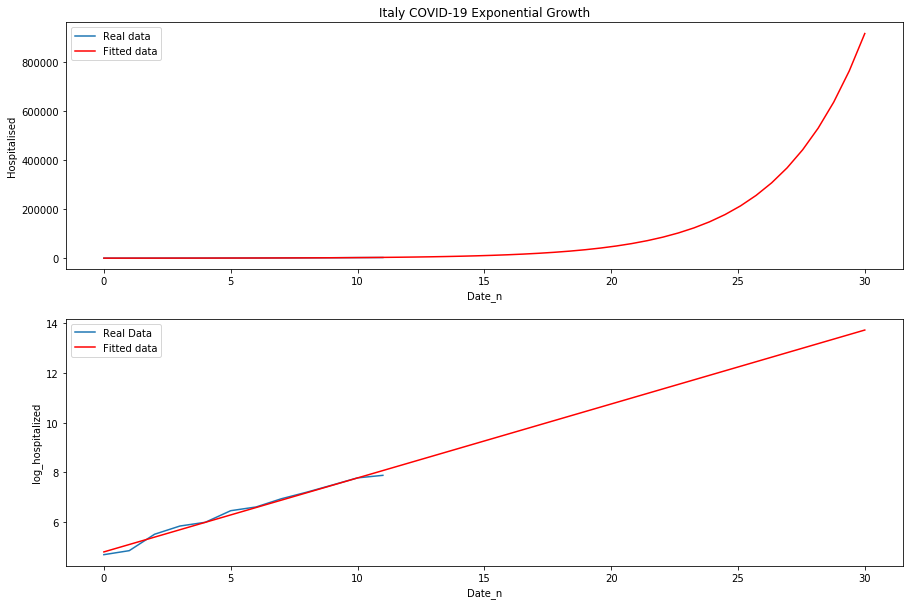

In [36]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
fig.set_size_inches(15,10)

ax1.set_title('Italy COVID-19 Exponential Growth')

sns.lineplot(df_g.Date_n, df_g.Hospitalised, ax=ax1, label='Real data')
sns.lineplot(x=df_predicted.Date_n,y=predicted, color='red', ax=ax1, label='Fitted data')
sns.lineplot(df_g.Date_n, df_g.Hospitalised.apply(lambda x: math.log(x)), ax=ax2, label='Real Data')
sns.lineplot(x=df_predicted.Date_n,y=log_predicted, color='red', ax=ax2, label='Fitted data')
ax2.set_ylabel('log_hospitalized')